In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import scipy as osp
from scipy.stats import kde

import paragami

import matplotlib.pyplot as plt
%matplotlib inline

from bnpmodeling_runjingdev import log_phi_lib, cluster_quantities_lib, influence_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
from bnpmodeling_runjingdev.sensitivity_lib import \
        HyperparameterSensitivityLinearApproximation

from structure_vb_lib import structure_model_lib, posterior_quantities_lib
from structure_vb_lib.data_utils import cluster_admix_get_indx
from structure_vb_lib.preconditioner_lib import get_mfvb_cov_matmul

import structure_vb_lib.structure_optimization_lib as s_optim_lib

import re
import copy

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [3]:
# data_file='../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'
# out_filename='huang2011_fit'
# out_folder='../fits/hgdp_fits/'

data_file = '../data/huang2011_sub_nobs25_nloci75.npz'
out_filename = 'huang2011_fit_sub'
out_folder = '../fits/tmp/'


In [4]:
alpha0 = 6.0

init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
lr_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_lrderivatives.npz'

# Load data

In [5]:
print(data_file)

../data/huang2011_sub_nobs25_nloci75.npz


In [6]:
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [7]:
g_obs.shape

(25, 75, 3)

# Load initial fit

In [8]:
print(init_fit_file)

../fits/tmp/huang2011_fit_sub_alpha6.0.npz


In [9]:
vb_init_dict, vb_params_paragami, \
    prior_params_dict, prior_params_paragami, \
        gh_loc, gh_weights, init_fit_meta_data = \
            structure_model_lib.load_structure_fit(init_fit_file)

In [10]:
vb_init_free = vb_params_paragami.flatten(vb_init_dict, free = True)

# Define vb sensitivity 

We need the hessian solver ... 

In [11]:
stru_objective = s_optim_lib.StructureObjective(g_obs, 
                                                vb_params_paragami,
                                                prior_params_dict, 
                                                gh_loc, gh_weights, 
                                                jit_functions = False)

In [12]:
cg_precond = lambda v : get_mfvb_cov_matmul(v, vb_init_dict,
                                            vb_params_paragami,
                                            return_sqrt = False, 
                                            return_info = True)


In [13]:
vb_sens = HyperparameterSensitivityLinearApproximation(
                    objective_fun = stru_objective.f, 
                    opt_par_value = vb_init_free, 
                    hyper_par_value0 = np.array([0.]), 
                    obj_fun_hvp = stru_objective.hvp, 
                    # doens't matter for now; we just want the hessian solver
                    hyper_par_objective_fun = lambda x, y : 0., 
                    cg_precond = cg_precond, 
                    cg_tol = 1e-8,
                    cg_maxiter = None)

NOTE: using custom hvp
Compiling hessian solver ...
Hessian solver compile time: 96.9905sec

Compiling cross hessian...
Cross-hessian compile time: 0.0527782sec

LR sensitivity time: 0.0345674sec



# Influence functions

In [14]:
logit_v_grid = np.linspace(-10, 10, 200)

In [15]:
def get_influence(g, grad_g = None): 
    if grad_g is None: 
        print('computing gradient')
        get_grad_g = jax.jacobian(g, argnums = 0)
        grad_g = get_grad_g(vb_init_free)

    # get influence function
    influence_operator = influence_lib.InfluenceOperator(vb_init_free, 
                               vb_params_paragami, 
                               vb_sens.hessian_solver,
                               prior_params_dict['dp_prior_alpha'], 
                               stick_key = 'ind_admix_params')
    
    influence_grid, grad_g_hess_inv = influence_operator.get_influence(logit_v_grid, 
                                                                       grad_g)

    return influence_grid, grad_g_hess_inv

### Influence function for expected number of obs per cluster

In [16]:
def get_e_num_ind(vb_free, k = 0): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(stick_means, 
                                                                     stick_infos, 
                                                                     gh_loc, 
                                                                     gh_weights)
    
    # select a 'k' before summing ... otherwise throws a memory error
    # this is probably more efficient
    return e_ind_admix[:, k].sum()

    # return posterior_quantities_lib.get_e_num_ind_per_cluster(vb_params_dict, gh_loc, gh_weights)[k]

# def get_e_num_loci(vb_free, k = 0): 
#     vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
#     return posterior_quantities_lib.get_e_num_loci_per_cluster(g_obs, vb_params_dict, gh_loc, gh_weights)[k]

In [17]:
influence_grid_e_num_ind0, ghess_e_num_ind0 = get_influence(lambda x : get_e_num_ind(x, k = 0))
influence_grid_e_num_ind1, ghess_e_num_ind1 = get_influence(lambda x : get_e_num_ind(x, k = 1))
influence_grid_e_num_ind2, ghess_e_num_ind2 = get_influence(lambda x : get_e_num_ind(x, k = 2))

computing gradient
computing gradient
computing gradient


In [18]:
influence_results = dict(ghess_e_num_ind0 = ghess_e_num_ind0, 
                         ghess_e_num_ind1 = ghess_e_num_ind1, 
                         ghess_e_num_ind2 = ghess_e_num_ind2)

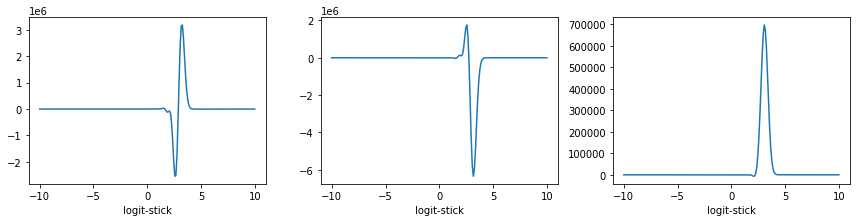

In [19]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3)) 
ax[0].plot(logit_v_grid, influence_grid_e_num_ind0)
ax[1].plot(logit_v_grid, influence_grid_e_num_ind1)
ax[2].plot(logit_v_grid, influence_grid_e_num_ind2)
fig.tight_layout();

for a in ax: 
    a.set_xlabel('logit-stick')

### Influence function on expected deviations in co-clustering

In [144]:
def get_coclustering_matr(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    # get individual admixtures
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(stick_means, 
                                                                     stick_infos, 
                                                                     gh_loc, 
                                                                     gh_weights)
    
    # return co-clusteirng
    return np.dot(e_ind_admix, e_ind_admix.transpose()).flatten()

In [1]:
grad_coclustering_matr = jax.jacobian(get_coclustering_matr)(vb_init_free)
signs = np.sign(grad_coclustering_matr)

subgrad_coclust_diffs = (grad_coclustering_matr * signs).sum(0)

NameError: name 'jax' is not defined

In [ ]:
influence_grid_coclust_diffs, ghess_coclust_diffs = get_influence(None, 
                                                                  subgrad_coclust_diffs)

# influence_grid_coclust_diffs, ghess_coclust_diffs = get_influence(lambda x : get_coclustering_matr(x).sum(), 
#                                                                   subgrad_coclust_diffs)

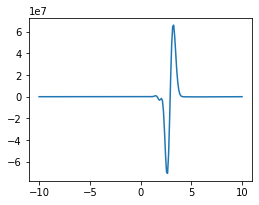

In [147]:
fig, ax = plt.subplots(1, 1, figsize = (4, 3)) 
ax.plot(logit_v_grid, influence_grid_coclust_diffs)

# Function to plot a perturbation

In [148]:
def plot_perturbation(perturbation, delta): 
        
    # need the bare minimum to make plots
    f_obj_all = log_phi_lib.LogPhiPerturbations(vb_params_paragami = vb_params_paragami, 
                                                 alpha0 = alpha0,
                                                 gh_loc = gh_loc, 
                                                 gh_weights = gh_weights,
                                                 logit_v_grid = None, 
                                                 influence_grid = None, 
                                                 delta = delta,
                                                 stick_key = 'ind_admix_params')

    f_obj = getattr(f_obj_all, 'f_obj_' + perturbation)
    
    # compute the prior perturbations
    prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = f_obj.log_phi, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
    
    prior_perturbation.plot_perturbation();
    
    return prior_perturbation, f_obj

# Function to load vb parameters

In [149]:
def load_refitted_free_params(perturbation, delta):     
        
    # get all files for that particular perturbation
    match_crit = out_filename + '_' + perturbation + '_delta{}_eps'.format(delta) + '\d+.npz'
    refit_files = [f for f in os.listdir(out_folder) if re.match(match_crit, f)]
    
    assert len(refit_files) > 0, 'no refit files found'
    
    # load files
    optim_time_vec = [init_fit_meta_data['optim_time']]
    epsilon_vec = [0.]
    vb_refit_list = [vb_init_free]
    delta_vec = []

    for i in range(len(refit_files)): 

        # print('loading fit from: ', refit_files[i])
        vb_params_dict, vb_params_paragami, meta_data = \
            paragami.load_folded(out_folder + refit_files[i])
        
        optim_time_vec.append(meta_data['optim_time'])
        epsilon_vec.append(meta_data['epsilon'])
        vb_refit_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))
        delta_vec.append(meta_data['delta'])
    
    delta = np.unique(np.array(delta_vec))
    # print('perturbation scaling (delta): ', delta)
    assert len(delta) == 1
    
    optim_time_vec = np.array(optim_time_vec)
    epsilon_vec = np.array(epsilon_vec)
    vb_refit_list = np.array(vb_refit_list)
    
    # sort the epsilons 
    _indx = np.argsort(epsilon_vec)
    optim_time_vec = optim_time_vec[_indx]
    epsilon_vec = epsilon_vec[_indx]
    vb_refit_list = vb_refit_list[_indx]
    
    print('Optim time at epsilon = 1: {:.3f}secs'.format(optim_time_vec[-1]))

    return vb_refit_list, epsilon_vec, delta

In [150]:
def plot_post_stats(g, vb_list, epsilon_vec, ax, label = '', color = 'red'): 
    
    # plots the posterior quantity as a function of epsilon
    
    post_vec = onp.zeros(len(epsilon_vec))
    
    for i in range(len(epsilon_vec)): 
        post_vec[i] = g(vb_list[i])

    # plot
    ax.plot(epsilon_vec,
            post_vec, 
            'o-', 
            color = color,
            label = label)
    
    return post_vec

In [151]:
def plot_results_for_refit_and_lr(g, vb_refit_list, lr_list, epsilon_vec, ax): 
    
    post_vec_refit = plot_post_stats(g,
                                     vb_refit_list,
                                     epsilon_vec, 
                                     ax,
                                     label = 'refit', 
                                     color = '#1b9e77')
    
    post_vec_lr = plot_post_stats(g,
                                  lr_list,
                                  epsilon_vec,
                                  ax,
                                  label = 'lr', 
                                  color = '#d95f02')
    
    return post_vec_refit, post_vec_lr

# Plot results

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.412626e-07
  warnings.warn(


Optim time at epsilon = 1: 5.434secs
Compiling cross hessian...
Cross-hessian compile time: 0.0529611sec

LR sensitivity time: 0.704801sec



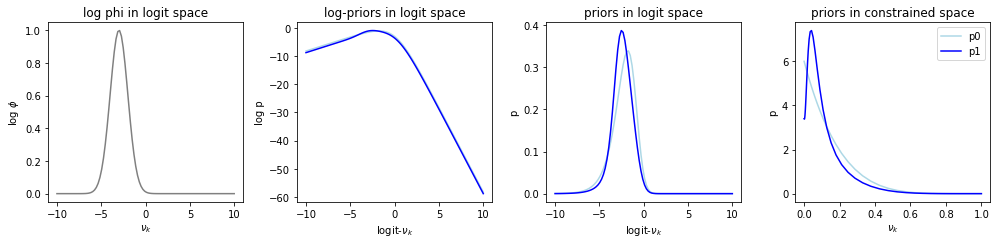

In [169]:
perturbation = 'gauss_pert2'
delta = 1

prior_perturbation, f_obj = plot_perturbation(perturbation, delta)

##############
# Load refit results
##############
vb_refit_list, epsilon_vec, delta = \
    load_refitted_free_params(perturbation, delta)

##############
# get linear response results
##############
vb_sens._set_cross_hess_and_solve(f_obj.hyper_par_objective_fun)

lr_list = []
for epsilon in epsilon_vec: 
    # get linear response
    lr_list.append(vb_init_free + vb_sens.dinput_dhyper * epsilon * delta)
lr_list = np.array(lr_list)

### Plot results for expected cluster belongings

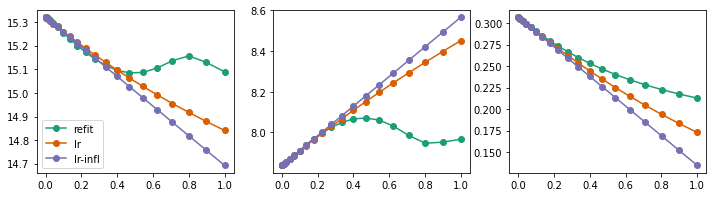

In [170]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3)) 

for k in range(3): 
    # plot linear response results
    post_vec_refit, post_vec_lr = \
        plot_results_for_refit_and_lr(lambda x : get_e_num_ind(x, k = k), 
                                      vb_refit_list,
                                      lr_list,
                                      epsilon_vec = epsilon_vec, 
                                      ax = ax[k])

    ##############
    # get linear response with influence operator
    ##############
    dg_dhyper = np.dot(influence_results['ghess_e_num_ind{}'.format(k)],
                       vb_sens.cross_hess.squeeze())
    lr2_vec = post_vec_refit[0] + dg_dhyper * epsilon_vec

    ax[k].plot(epsilon_vec,
                lr2_vec,
                'o-', 
                color = '#7570b3',
                label = 'lr-infl')

ax[0].legend()


### Results on deviation from co-clustering

In [171]:
def get_coclust_diffs(vb_free): 
    return np.abs(get_coclustering_matr(vb_free) - \
                  get_coclustering_matr(vb_init_free)).sum()

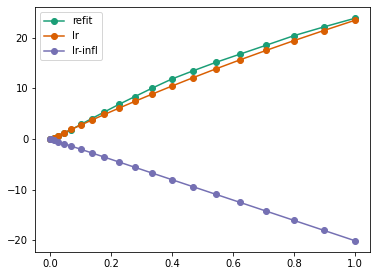

In [175]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4.5)) 
post_vec_refit, post_vec_lr = \
    plot_results_for_refit_and_lr(get_coclust_diffs, 
                                  vb_refit_list,
                                  lr_list,
                                  epsilon_vec = epsilon_vec, 
                                  ax = ax)

##############
# get linear response with influence operator
##############
dg_dhyper = np.dot(ghess_coclust_diffs,
                   vb_sens.cross_hess.squeeze())
lr2_vec = post_vec_refit[0] + dg_dhyper * epsilon_vec

ax.plot(epsilon_vec,
            lr2_vec,
            'o-', 
            color = '#7570b3',
            label = 'lr-infl')

ax.legend()